# Data Driven Building predictions


## Part 1: Setting the datas  (Assignment 9)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 

Importing the external files:

In [2]:
ExternalFilesFolder =  r"C:\Users\Gilberto\Desktop\poli\Energy building systems\Data-driven_Building_simulation_Polimi_EETBS\Data"
ConsumptionFileName= "consumption_5545.csv"
TemperatureFileName= "Austin_weather_2014.csv"
IrradianceFileName= "irradiance_2014_gen.csv"

path_consumptionFile = os.path.join(ExternalFilesFolder,ConsumptionFileName)
path_TemperatureFile = os.path.join(ExternalFilesFolder,TemperatureFileName)
path_IrradianceFile = os.path.join(ExternalFilesFolder,IrradianceFileName)

Reading the files, changing the indexes (so it's possible to use them as time datas) and setting Data Frames for the needed datas: temperature, AC consumption and irradiance (wich is correlated to the PV generation):

In [3]:
DF_consumption = pd.read_csv(path_consumptionFile,sep=",", index_col=0)

PreviousIndex = DF_consumption.index
NewParsedIndex= pd.to_datetime(PreviousIndex)
DF_consumption.index =NewParsedIndex 

DF_weather = pd.read_csv(path_TemperatureFile,sep=";",index_col=0)

previousIndex_weather=DF_weather.index
newIndex_weather=pd.to_datetime(previousIndex_weather)
DF_weather.index = newIndex_weather

DF_Temperature= DF_weather[["temperature"]]


DF_irradianceSource = pd.read_csv(path_IrradianceFile,sep=";",index_col=1)

DF_irradiance=DF_irradianceSource[["gen"]]
DF_irradiance[DF_irradiance["gen"]<0] = 0 #setting at zero all the negative datas
previousIndex_irr=DF_irradiance.index
newIndex_irr=pd.to_datetime(previousIndex_irr)
DF_irradiance.index = newIndex_irr

C:\Users\Gilberto\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\ipykernel\__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Gilberto\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\pandas\core\frame.py:2346: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer(indexer, value)
C:\Users\Gilberto\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\pandas\core\frame.py:2326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas

Creating a joined data frame wich contains all my datas and making a copy of it, which will be modified in order to make predictions ( temperature datas are shifted due to the different time zone of the measurements):

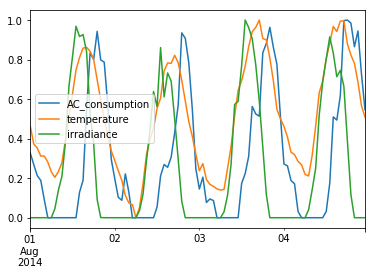

In [4]:
DF_joined = DF_consumption.join([DF_Temperature,DF_irradiance])

DF_mod = DF_joined.copy()
DF_mod["temperature"]=DF_mod["temperature"].shift(-5)
DF_mod.dropna(inplace=True)
DF_mod.columns=["AC_consumption", "temperature","irradiance"]

#plotting a normalized version of my DF to see the qualitative behaviour:
DF_mod_chosenDates = DF_mod["2014-08-01":"2014-08-04"]
DF_mod_normalized= (DF_mod_chosenDates-DF_mod_chosenDates.min())/(DF_mod_chosenDates.max()-DF_mod_chosenDates.min())
DF_mod_normalized.plot()
plt.show()

Creating a "lag_feature" function and applying it to my modified data frame in order to have meaningful datas for my predictions

In [5]:
def lag_feature(df,column_name,lag_start,lag_end,lag_interval):
    for i in range(lag_start,lag_end+1,lag_interval):
        new_column_name = column_name+" -"+str(i)+"hr"
        df[new_column_name]=df[column_name].shift(i)   
        df.dropna(inplace=True) #this removes all the row with a Nan
    return df
    
DF_mod=lag_feature(DF_mod,"temperature",1,6,1)
DF_mod=lag_feature(DF_mod,"irradiance",3,6,1)
DF_mod=lag_feature(DF_mod,"AC_consumption",1,24,1)

Let's add time-related parameters extracted from the indexes converted before:

In [6]:
DF_mod["hour"]=DF_mod.index.hour

DF_mod["day_of_week"]=DF_mod.index.dayofweek

DF_mod["month"]=DF_mod.index.month

DF_mod["week_of_year"]=DF_mod.index.week


I need to correlate time and consumption, but time always restart from 0 while consumption values are continuous. To avoid this problem, I convert "hour" into a radiant angle so it's possible to use sin and cos functions with it:

In [7]:
DF_mod["sin_hour"]=np.sin(DF_mod.index.hour*2*np.pi/24)
DF_mod["cos_hour"]=np.cos(DF_mod.index.hour*2*np.pi/24)

Adding and applying other 2 features for improving my predictions: WeekendDetector to know if the day is a working day or not, and DayDetector to set the working hours in a day :

In [8]:
def WeekendDetector(day):
    if (day==5 or day == 6):
        weekendLabel=1
    else:
        weekendLabel=0
    return weekendLabel

DF_mod["weekend"]= DF_mod["day_of_week"].apply(WeekendDetector)
    
def DayDetector(hour):
    if (hour< 19 and hour>=9):
        DayLabel=1
    else:
        DayLabel=0
    return DayLabel

DF_mod["workingTime"] = DF_mod["hour"].apply(DayDetector)

looking for correlations between all my datas:

In [9]:
DF_mod.corr()

,AC_consumption,temperature,irradiance,temperature -1hr,temperature -2hr,temperature -3hr,temperature -4hr,temperature -5hr,temperature -6hr,irradiance -3hr,...,AC_consumption -23hr,AC_consumption -24hr,hour,day_of_week,month,week_of_year,sin_hour,cos_hour,weekend,workingTime
AC_consumption,1.000000,0.568967,-0.012695,0.608771,0.637029,0.650286,0.647997,0.630508,0.598963,0.364543,...,0.849304,0.899850,0.361070,-0.014515,0.128627,0.139760,-0.438641,0.212579,-0.005932,-0.053224
temperature,0.568967,1.000000,0.327736,0.990924,0.968215,0.935052,0.894855,0.850852,0.805907,0.450232,...,0.578146,0.538885,0.243124,0.038664,0.162804,0.193112,-0.332523,-0.146285,0.037955,0.247145
irradiance,-0.012695,0.327736,1.000000,0.238627,0.141066,0.043916,-0.044694,-0.118168,-0.172384,0.560763,...,0.091944,-0.025262,0.167131,-0.029183,-0.034465,-0.026719,-0.237118,-0.740835,-0.031255,0.766372
temperature -1hr,0.608771,0.990924,0.238627,1.000000,0.990924,0.968215,0.935050,0.894848,0.850835,0.440053,...,0.606575,0.578143,0.262693,0.037578,0.163573,0.193957,-0.359332,-0.054764,0.037937,0.167417
temperature -2hr,0.637029,0.968215,0.141066,0.990924,1.000000,0.990923,0.968213,0.935045,0.894836,0.398205,...,0.620548,0.606578,0.269813,0.036610,0.164362,0.194789,-0.361499,0.040584,0.037825,0.079101
temperature -3hr,0.650286,0.935052,0.043916,0.968215,0.990923,1.000000,0.990923,0.968210,0.935035,0.327602,...,0.619483,0.620549,0.261097,0.035980,0.165203,0.195631,-0.338919,0.133246,0.038007,-0.010368
temperature -4hr,0.647997,0.894855,-0.044694,0.935050,0.968213,0.990923,1.000000,0.990922,0.968205,0.238492,...,0.604101,0.619488,0.231785,0.035539,0.166071,0.196473,-0.293132,0.216867,0.038456,-0.094670
temperature -5hr,0.630508,0.850852,-0.118168,0.894848,0.935045,0.968210,0.990922,1.000000,0.990920,0.140920,...,0.575197,0.604109,0.176851,0.035229,0.167000,0.197279,-0.227286,0.285755,0.038891,-0.169806
temperature -6hr,0.598963,0.805907,-0.172384,0.850835,0.894836,0.935035,0.968205,0.990920,1.000000,0.043755,...,0.535692,0.575207,0.102506,0.034955,0.167940,0.198039,-0.145865,0.335197,0.039206,-0.232576
irradiance -3hr,0.364543,0.450232,0.560763,0.440053,0.398205,0.327602,0.238492,0.140920,0.043755,1.000000,...,0.442520,0.342982,0.465340,-0.029040,-0.034603,-0.026854,-0.691844,-0.355625,-0.031306,0.536995


## Part 2: Prediction models (Assignment 10)

In [10]:
df_mod=DF_mod["2014-03-01":"2014-09-30"]
DF_target= df_mod["AC_consumption"] 
DF_features= df_mod.drop("AC_consumption", axis=1)

All the training and validation models are imported from sklearn (scikit-learn), a machine-learning opensource library, built on NumPy and matplotlib, which contains efficient tools for data mining and data analysis.

Let's first try with train_test_split model for managing train and test datas and the linear regression model for predictions

In [11]:
from sklearn.model_selection import train_test_split 

X_train, X_test, Y_train, Y_test = train_test_split(DF_features,DF_target,test_size = 0.2, random_state=41234) #way we give train and tests

from sklearn import linear_model
linear_reg = linear_model.LinearRegression()

Fitting the model:

In [12]:
linear_reg.fit(X_train, Y_train)

predicted_linearReg_split = linear_reg.predict(X_test)

predicted_DF_linearReg_split=pd.DataFrame(predicted_linearReg_split,index=Y_test.index, columns=["AC_cons_predicted_linearReg_split"])
predicted_DF_linearReg_split=predicted_DF_linearReg_split.join(Y_test)

Let's qualitatively see if it works

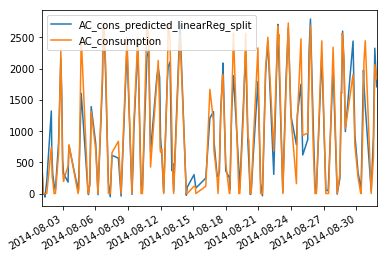

In [13]:
predicted_DF_linearReg_split_august=predicted_DF_linearReg_split["2014-08-01":"2014-08-31"]
predicted_DF_linearReg_split_august.plot()
plt.show(1)

Now we want to quantitatively know how accurate the predictions are.
To do this, we import other 3 features that we need to calculate 3 indexes of accuracy:
    - mean absolute error
    - mean squared error
    - R^2  

In [14]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

Accuracy of the linear regression model with train_test_split:

In [15]:
MAE_linearReg_split= mean_absolute_error(predicted_linearReg_split,Y_test)
MSE_linearReg_split= mean_squared_error(predicted_linearReg_split,Y_test)
R2_linearReg_split = r2_score(predicted_linearReg_split,Y_test)
R2_linearReg_split

0.87578696798025291

Now, let's use k-fold validation instead of the train_test_split with the linear regression model:

In [16]:
from sklearn.model_selection import cross_val_predict

predict_linearReg_CV = cross_val_predict(linear_reg,DF_features,DF_target,cv=10)

predicted_DF_linearReg_CV=pd.DataFrame(predict_linearReg_CV, index=DF_target.index, columns=["AC_cons_predicted_linearReg_CV"])
predicted_DF_linearReg_CV=predicted_DF_linearReg_CV.join(DF_target)

Qualitative behaviour:

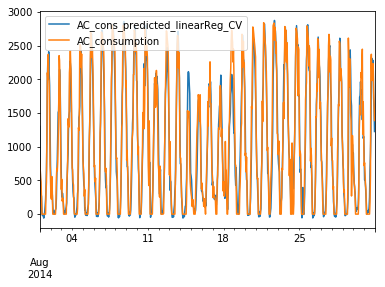

In [17]:
predicted_DF_linearReg_CV_august=predicted_DF_linearReg_CV["2014-08-01":"2014-08-31"]
predicted_DF_linearReg_CV_august.plot()
plt.show()

Accuracy:

In [18]:
MAE_linearReg_CV= mean_absolute_error(predict_linearReg_CV,DF_target)
MSE_linearReg_CV= mean_squared_error(predict_linearReg_CV,DF_target)
R2_linearReg_CV = r2_score(predict_linearReg_CV,DF_target)

R2_linearReg_CV

0.8781113464815159

Now, still using cross validation method, Let's try "Random Forest" algorithm:

In [19]:
from sklearn.ensemble import RandomForestRegressor
reg_RF = RandomForestRegressor()

predict_RF_CV = cross_val_predict(reg_RF,DF_features,DF_target,cv=10)

predicted_DF_RF_CV=pd.DataFrame(predict_RF_CV,
                                       index=DF_target.index, 
                                       columns=["AC_cons_predicted_RF_CV"])
predicted_DF_RF_CV=predicted_DF_RF_CV.join(DF_target)

Qualitative behaviour:

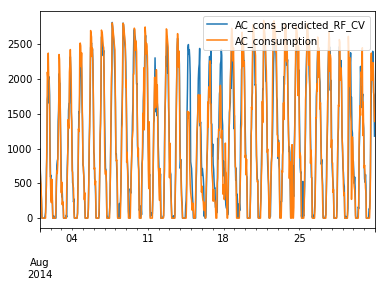

In [20]:
predicted_DF_RF_CV_august=predicted_DF_RF_CV["2014-08-01":"2014-08-31"]
predicted_DF_RF_CV_august.plot()
plt.show()

RF's accuracy

In [21]:
MAE_RF_CV= mean_absolute_error(predict_RF_CV,DF_target)
MSE_RF_CV= mean_squared_error(predict_RF_CV,DF_target)
R2_RF_CV = r2_score(predict_RF_CV,DF_target)

R2_RF_CV

0.90436837793869773

#### Now, let's use Online learning: 
We will still use the Random Forest algorithm, but we'll manage train and test datas. 

Setting the time steps and the data frame that will include my predictions 

In [22]:
DF_onlineConsumptionPrediction = pd.DataFrame(index=DF_mod.index)

period_of_training = pd.Timedelta(30, unit="d")

FirstTimeStamp_measured = df_mod.index[0]
LastTimeStamp_measured = df_mod.index[-1]

FirstTimeStamp_toPredict= FirstTimeStamp_measured+period_of_training

training_startTimeStamp=FirstTimeStamp_measured
training_endTimeStamp=FirstTimeStamp_toPredict
timeStamp_toPredict= FirstTimeStamp_toPredict

Setting the while cycle for predicting the "next hour consumption", always moving the period of training 1 hour forward togheter with the hour that has to be predicted in order to avoid  the presence of misleading datas and always have a 1-month training period (the one right before the time stamp to predict)

In [23]:
while (timeStamp_toPredict< LastTimeStamp_measured):
    DF_feature_train=DF_features.truncate(before=training_startTimeStamp,after=training_endTimeStamp)
    DF_target_train= DF_target.truncate(before=training_startTimeStamp,after=training_endTimeStamp)
    
    DF_feature_test = DF_features.loc[timeStamp_toPredict].values.reshape(1,-1) 
    DF_target_test=DF_target.loc[timeStamp_toPredict]
    reg_RF.fit(DF_feature_train,DF_target_train) 
    predicted_Consumption = reg_RF.predict(DF_feature_test)
    DF_onlineConsumptionPrediction.loc[timeStamp_toPredict,"Predicted"]=predicted_Consumption
    DF_onlineConsumptionPrediction.loc[timeStamp_toPredict,"Real"] = DF_target_test

    
    timeStamp_toPredict=timeStamp_toPredict+pd.Timedelta(1, unit="h")
    training_endTimeStamp=training_endTimeStamp+pd.Timedelta(1, unit="h")
    training_startTimeStamp=training_startTimeStamp + pd.Timedelta(1, unit="h")

DF_onlineConsumptionPrediction.dropna(inplace=True)

Accuracy:

In [24]:
R2_score_online_RF = r2_score(DF_onlineConsumptionPrediction[["Real"]], DF_onlineConsumptionPrediction[["Predicted"]])
R2_score_online_RF

0.9822501816885556